In [100]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
# mpl.rcParams['figure.autolayout'] = True

import pca

# Applications

## Compress images

In [2]:
def show_img(im, title=None, ax=None):
    ax = ax or plt.gca()
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

Image size: (1494, 1038)
Preview:


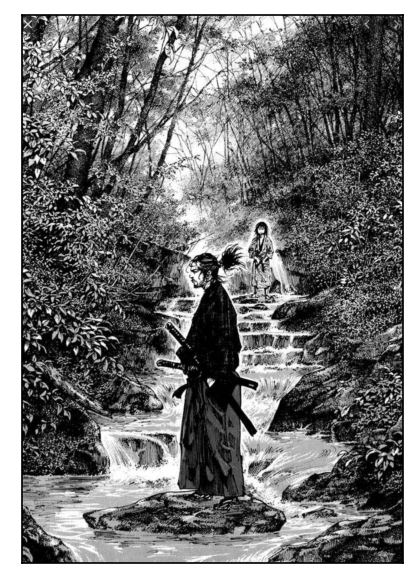

In [3]:
# Load image
im = Image.open('input/images/sample.jpg').convert('L')
im_arr = np.array(im)
print('Image size:', im_arr.shape)

# Preview
print('Preview:')
show_img(im_arr)
plt.show()

In [4]:
output_dir = 'output/images/sample/imgs'

h, w = im_arr.shape

ks = np.arange(0, 1001, 10)[1:]
imks = np.zeros(shape=(len(ks), h, w))

for i, k in enumerate(ks):
    Uk, x_mean, Z = pca.compress(im_arr, k)
    im_compressed = pca.decode(Uk, x_mean, Z)
    imks[i] = im_compressed

In [5]:
for k, im in zip(ks, imks):
    Image.fromarray(im).convert('L').save(output_dir + '/' + f'I{k:04d}.jpg')

In [8]:
errorks = np.zeros(len(ks))
rks = np.zeros(len(ks))

for i, k in enumerate(ks):
    errorks[i] = np.linalg.norm(im_arr - imks[i]) / np.linalg.norm(im_arr)

    ori_size = h * w
    cpr_size = 4 * (h * k + w + k * w)
    rks[i] = cpr_size / ori_size

In [9]:
f = open('output/images/sample/rk.txt', 'w')
for k, rk in zip(ks, rks):
    f.write(f'k = {k:4d}: {rk:.9f}\n')
f.close()

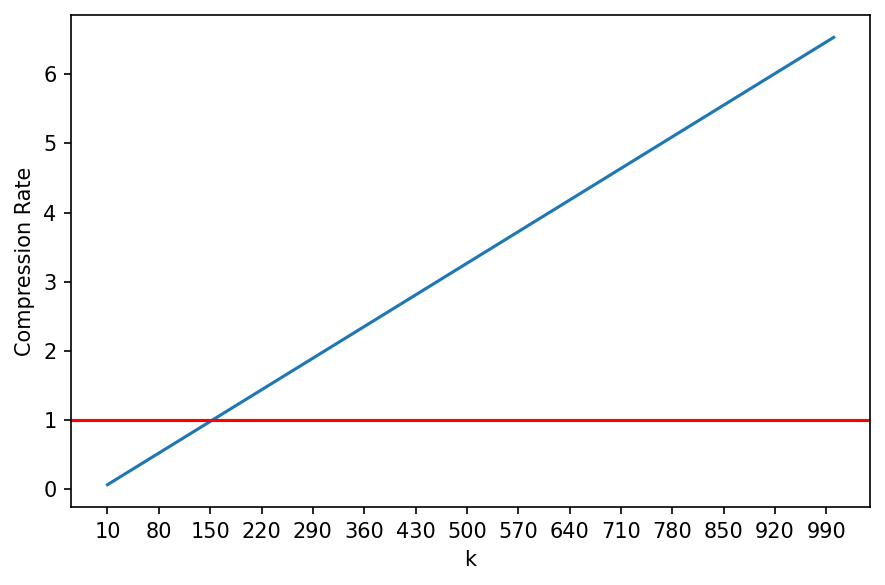

In [20]:
plt.plot(ks, rks)
plt.xticks(ks[np.arange(0, len(ks), 7)])

plt.axhline(1, 0, 1, color='r')

plt.xlabel('k')
plt.ylabel('Compression Rate')

plt.savefig('output/images/sample/compression-rate')

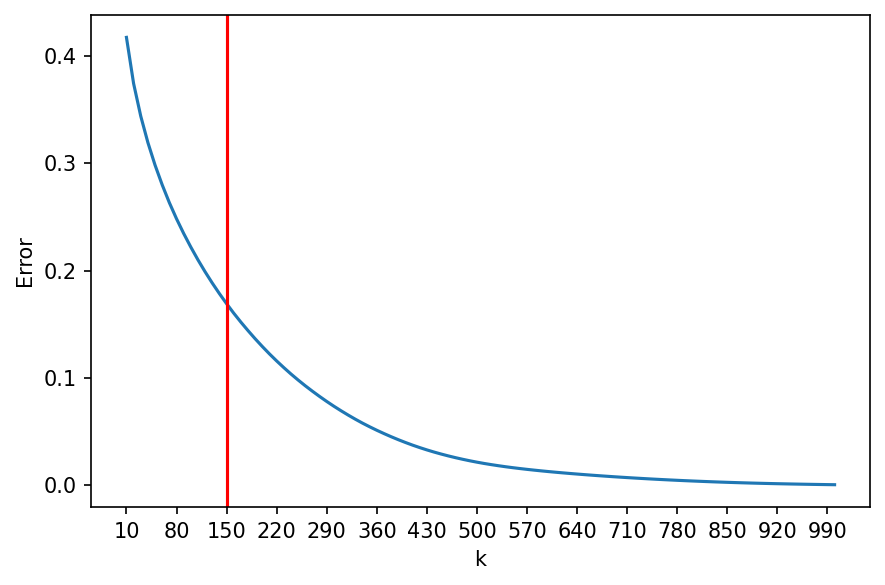

In [22]:
plt.plot(ks, errorks)
plt.xticks(ks[np.arange(0, len(ks), 7)])

plt.axvline(150, 0, 1, color='r')

plt.xlabel('k')
plt.ylabel('Error')

plt.savefig('output/images/sample/error')

## Compress audio files

In [2]:
def pad(x, sz):
    if len(x) % sz == 0:
        return x
    pad = sz - len(x) % sz
    x_padded = np.zeros(len(x) + pad)
    x_padded[:len(x)] = x
    return x_padded

In [94]:
import scipy.io.wavfile

sr, arr = scipy.io.wavfile.read('input/audios/sample.wav')
arr = arr[:, 0]

(50678,)


In [99]:
au_arr_padded = pad(arr, 215)
au_arr = au_arr_padded.reshape((-1, 215))

Uk, x_mean, Z = pca.compress(au_arr, 10)
au_compressed = pca.decode(Uk, x_mean, Z)

au_compressed = (au_compressed.reshape(-1)[:len(arr)]).astype(np.int16)
scipy.io.wavfile.write('test.wav', sr, au_compressed)

In [83]:
print(arr.dtype)

int16


0.18647144717628952

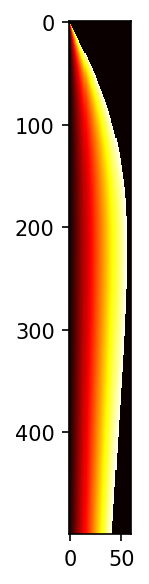

In [101]:
l = len(arr)

N, M = 500, 60
r = np.zeros((N, M))
for b in range(1, N):
    for k in range(1, M):
        ori_sz = 2 * l
        h, w = (l // b + (l % b > 0)), b
        cpr_sz =  4 * (h * k + w + w * k)
        r[b, k] = cpr_sz / ori_sz
r[r >= 1] = 0

plt.imshow(r, cmap='hot', interpolation='nearest')